# 평균이동


데이터의 밀도가 가장 높은 곳으로 이동시킨다. <br>
군집 중심점을 확률 밀도 함수를 이용해서 찾는다.<br>
KDE를 이용해서 가장 밀도가 높은 곳으로 이동한다.

#### 확률 밀도함수의 종류
- 정규 분포 함수
- 감마 분포
- t 분포

### 커널함수를 적용한 뒤 이 적용 값을 모두 더한 후 관측 데이터의 건수로 나눠서 확률 밀도함수를 추정한다.

부드러운 형태로 평활화 하는 데 적용되며 h를 어떻게 설정하느냐에 따라 확률 밀도 추정을 크게 좌우할 수 있다. 작은 h 값은 좁고 뾰족한 KDE를 가지게 되며 큰 h 값은 과도하게 평활화 된 KDE로 인해 지나치게 단순화된 방식으로 확률 밀도 함수를 추정하며 과소적합하기 쉽다. 따라서 적절한 폭 h를 계산하는 것이 중요하다.

In [3]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, 
                  cluster_std=0.7, random_state=0)

meanshift= MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5]


In [4]:
meanshift= MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))
# bandwidth 값을 작게 할 수록 군집 개수가 많아진다.

cluster labels 유형: [0 1 2]


#### 최적화된 bandwidth값을 찾는 방법.

In [5]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X,quantile=0.2)
print('bandwidth 값:', round(bandwidth,3))

bandwidth 값: 1.285


In [6]:
import pandas as pd


clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

# estimate_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(X, quantile=0.2)

meanshift= MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:',np.unique(cluster_labels))    

cluster labels 유형: [0 1 2]


In [7]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth,3))

bandwidth 값: 1.816


In [9]:
import pandas as pd


clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

# estimate_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(X, quantile=0.2)

meanshift= MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:',np.unique(cluster_labels)) 

cluster labels 유형: [0 1 2]


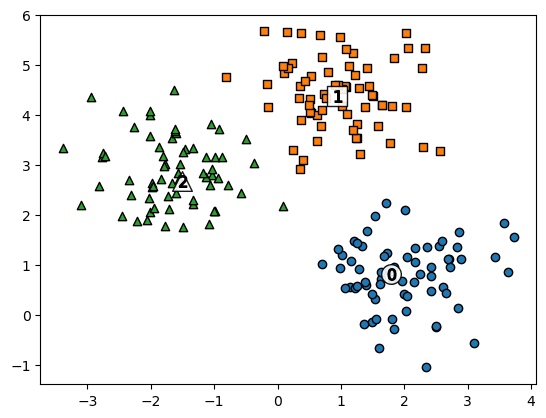

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label']  = cluster_labels
centers = meanshift.cluster_centers_ # 중심을 찾는 클래스 내부 함수와 같다.
unique_labels = np.unique(cluster_labels)
markers=['o', 's', '^', 'x', '*']

for label in unique_labels:
    label_cluster = clusterDF[clusterDF['meanshift_label']==label]
    center_x_y = centers[label]
    # 군집별로 다른 marker로 scatter plot 적용
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', 
                marker=markers[label] )
    
    # 군집별 중심 시각화
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='white',
                edgecolor='k', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', 
                marker='$%d$' % label)
    
plt.show()


In [11]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       1                  67
1       0                  67
2       2                  66
Name: count, dtype: int64


데이터 세트의 형태를 특정형태로 가정한다든가 특정 분포도 기반의 모델로 가정하지 않기 때문에 유연한 군집화가 가능하다.

## GMM

여러 개의 가우시안 분포를 가진 데이터 집합들이 섞여서 생성된 것이라는 가정하에 군집화를 수행하는 방식이다.<br>
대칭형의 종 형태를 가진 통계학에서 가장 잘 알려진 연속 확률 함수이다.

여러 개의 정규 분포 곡선을 추출하고 개별 데이터가 이 중 어떤 정규 분포에 속하는지 결정하는 방식이다.
parameter(모수) 추정은 대표적으로 2가지를 추정하는 것이다.<br>
- 개별 정규 분포의 평균과 분산
- 각 데이터가 어떤 정규 분포에 해당되는 지의 확률

In [12]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

# 보다 편리한 데이타 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [13]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

# 클러스터링 결과를 irisDF 의 'gmm_cluster' 컬럼명으로 저장
irisDF['gmm_cluster'] = gmm_cluster_labels
irisDF['target'] = iris.target

# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인. 
iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       1              50
1       0              45
        2               5
2       2              50
Name: count, dtype: int64


c:\Users\whgy1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [14]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

c:\Users\whgy1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\whgy1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


target  kmeans_cluster
0       1                 50
1       0                 48
        2                  2
2       2                 36
        0                 14
Name: count, dtype: int64


In [15]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수  
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

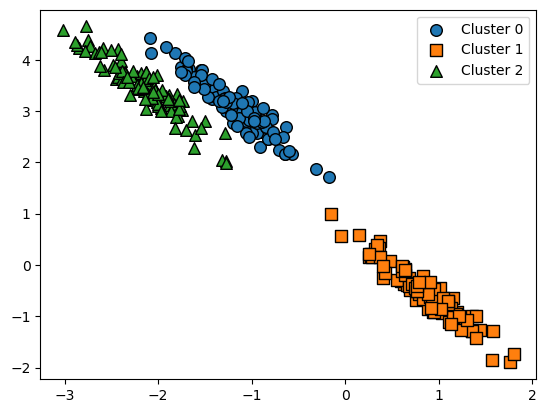

In [16]:
from sklearn.datasets import make_blobs

# make_blobs() 로 300개의 데이터 셋, 3개의 cluster 셋, cluster_std=0.5 을 만듬. 
X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타원형의 데이터 셋을 생성하기 위해 변환함. 
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
# feature 데이터 셋과 make_blobs( ) 의 y 결과 값을 DataFrame으로 저장
clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y
# 생성된 데이터 셋을 target 별로 다른 marker 로 표시하여 시각화 함. 
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)


c:\Users\whgy1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\whgy1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


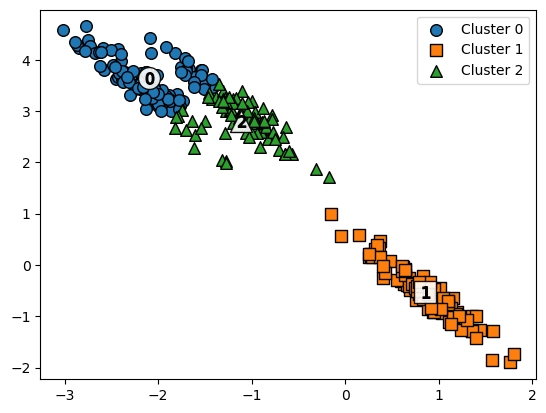

In [17]:
# 3개의 Cluster 기반 Kmeans 를 X_aniso 데이터 셋에 적용 
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label',iscenter=True)

c:\Users\whgy1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


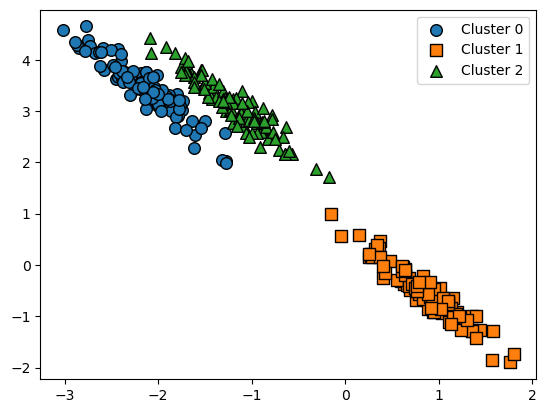

In [18]:
# 3개의 n_components기반 GMM을 X_aniso 데이터 셋에 적용 
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter를 False로 설정. 
visualize_cluster_plot(gmm, clusterDF, 'gmm_label',iscenter=False)


In [19]:
print('### KMeans Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: count, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: count, dtype: int64


## DBSCAn

밀도 기반 군집화의 대표적인 알고리즘이다. 간단하고 직관적인 알고리즘이다.
